In [2]:
!nvidia-smi

Sun May 19 02:39:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 551.68         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P5             15W /  200W |    1212MiB /  12282MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. 비영어권 국가 학생들의 영어 발음 데이터. train 2500개, test 2500개.

In [3]:
from datasets import load_dataset
train_set = load_dataset("mispeech/speechocean762", split="train")

In [4]:
train_set

Dataset({
    features: ['accuracy', 'completeness', 'fluency', 'prosodic', 'text', 'total', 'words', 'speaker', 'gender', 'age', 'audio'],
    num_rows: 2500
})

### 2. TTS (VITS) 로 데이터에 있는 문자를 음성으로 바꿔서 Ground truth 발음 만들기.

In [4]:
# Load VITS
from nemo.collections.tts.models import VitsModel

audio_generator = VitsModel.from_pretrained("tts_en_lj_vits")

import pandas as pd
import soundfile as sf
import torch

[NeMo I 2024-05-18 23:12:05 cloud:58] Found existing object /home/kyudan/.cache/torch/NeMo/NeMo_1.23.0/vits_ljspeech_fp16_full/aafc8db3ad2124ec6f77d4d20f3fddaf/vits_ljspeech_fp16_full.nemo.
[NeMo I 2024-05-18 23:12:05 cloud:64] Re-using file from: /home/kyudan/.cache/torch/NeMo/NeMo_1.23.0/vits_ljspeech_fp16_full/aafc8db3ad2124ec6f77d4d20f3fddaf/vits_ljspeech_fp16_full.nemo
[NeMo I 2024-05-18 23:12:05 common:924] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2024-05-18 23:12:20 deprecated:65] Function ``g2p_backward_compatible_support`` is deprecated. But it will not be removed until a further notice. G2P object root directory `nemo_text_processing.g2p` has been replaced with `nemo.collections.tts.g2p`. Please use the latter instead as of NeMo 1.18.0.
[NeMo W 2024-05-18 23:12:20 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2024-05-18 23:12:21 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-05-18 23:12:21 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` 

[NeMo I 2024-05-18 23:12:21 features:289] PADDING: 1
[NeMo I 2024-05-18 23:12:21 features:297] STFT using exact pad


[NeMo W 2024-05-18 23:12:21 nemo_logging:349] /home/kyudan/anaconda3/envs/nemo/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
      warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
    


[NeMo I 2024-05-18 23:12:22 save_restore_connector:249] Model VitsModel was successfully restored from /home/kyudan/.cache/torch/NeMo/NeMo_1.23.0/vits_ljspeech_fp16_full/aafc8db3ad2124ec6f77d4d20f3fddaf/vits_ljspeech_fp16_full.nemo.


In [8]:
train_text = [text.lower() for text in train_set['text']] 

In [9]:
train_text

['we call it bear',
 'zero three five one',
 'three two two seven',
 'elephants tai goose',
 'tom gives up boxing',
 'he hates shooting',
 'mandy has a big arm',
 "look at ann's pants",
 'what about the bus',
 'then he went to theme park',
 "let's go to the restroom",
 'then mike walks to coffee',
 'so mary went on to study',
 'kate got the tomato',
 'tina loves eggplant',
 'dora is not a cleaner',
 'mark lived in new york',
 'bob lives in cairo now',
 'bye',
 'trees',
 'mike likes the white one',
 'its name is say',
 'billy loves america',
 'two two eight seven',
 'four five four seven',
 'five three nine zero',
 'six five three',
 'two five eight',
 'we less meat',
 'dose mike like the hamburger',
 'annie want have some pretties',
 "kate's got some grey",
 "look at john's sweater",
 'tim has a beautiful tell',
 'jim likes your blue shore',
 'annie went walking them park',
 'layla can see the hometown',
 'so tina went on to washroom',
 'all with him',
 'good job',
 'jayme is going to 

In [15]:
train_text[0]

'we call it bear'

### 3. audio 생성.

In [19]:
for index, sentence in enumerate(train_text):

    with torch.no_grad():
        parsed = audio_generator.parse(sentence)
        audio = audio_generator.convert_text_to_waveform(tokens=parsed)

    # Save the audio to disk in a file called speech.wav
    if isinstance(audio, torch.Tensor):
        audio = audio.to("cpu").numpy()
    sf.write(f"./audios/eng_{index}.wav", audio.T, 22500, format="WAV", subtype="PCM_16")


[NeMo W 2024-05-18 23:20:35 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:36 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:36 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:36 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:36 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:37 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:37 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:37 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:37 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:37 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:38 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-18 23:20:38 vits:148] parse() is meant to be called in eval mode.
[NeMo W 2024-05-

### 4. 각각의 생성된 audio 들을 mel-spectrogram으로 바꿔서 list에 저장.

In [59]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 오디오 파일이 있는 디렉토리 경로
audio_dir = "./audios"

# Mel Spectrogram을 저장할 리스트
eng_mel = []

# 오디오 파일들을 순회
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        filepath = os.path.join(audio_dir, filename)
        
        # 오디오 파일 로드
        y, sr = librosa.load(filepath, sr=16000)
        
        # Mel Spectrogram 생성
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        
        # 로그 스케일 적용
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Mel Spectrogram 리스트에 추가
        eng_mel.append(mel_spec_db)


/tmp/ipykernel_1061/3309238218.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=16000)


EOFError: 

### 5. 데이터셋 상에 있던 음성들도 mel-spectrogram으로 변환.

In [3]:
from datasets import load_dataset
train_set = load_dataset("mispeech/speechocean762", split="train")
# Mel Spectrogram을 저장할 리스트
pseudo_mel = []

# 음성 파일 데이터를 순회
for audio_data in train_set['audio']:
    # 오디오 데이터와 샘플링 레이트 가져오기
    audio_array = np.array(audio_data['array'])
    sampling_rate = audio_data['sampling_rate']
    
    # Mel Spectrogram 생성
    mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_mels=128, fmax=8000)
    
    # 로그 스케일 적용
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Mel Spectrogram 리스트에 추가
    pseudo_mel.append(mel_spec_db)

### 6. 각각의 mel spectrogram 을 dataframe으로 정리.

In [4]:
import pandas as pd
df_mel = pd.DataFrame({
    'pseudo_mel': pseudo_mel,
    'eng_mel': eng_mel
})

In [5]:
df_mel

,pseudo_mel,eng_mel
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-65.578865, -61.58706, -59.194893, -62.21702..."
1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-64.083, -59.646873, -62.745033, -71.37704, ..."
2,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-74.43733, -65.5919, -64.79315, -70.021225, ..."
3,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-66.9301, -64.49806, -68.03508, -67.48627, -..."
4,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-72.22882, -70.692406, -70.469765, -67.04589..."
...,...,...
2495,"[[-55.445621275954196, -56.06079101296362, -56...","[[-65.06939, -61.689392, -60.450386, -56.06675..."
2496,"[[-55.03029305726948, -52.967788890050485, -52...","[[-69.96315, -63.436867, -62.71623, -58.660114..."
2497,"[[-53.93054647579497, -53.63944996244685, -51....","[[-74.93249, -78.64786, -79.17577, -66.44643, ..."
2498,"[[-54.182045993148506, -54.29826634391723, -56...","[[-63.140347, -60.72215, -63.85245, -66.71699,..."


In [6]:
df_mel['eng_mel'][0].shape

(128, 79)

### 7. model input으로 넣어주기 위해서 음성들의 최대 shape인 (128, 640) 으로 맞춰주기. 양쪽에 zero-padding 함.

In [7]:
import torch
import torch.nn as nn
# 원하는 크기
target_shape = (128, 640)

def resize_array(arr, target_shape):
    det = (target_shape[-1]-arr.shape[-1]) % 2
    pad = (target_shape[-1]-arr.shape[-1]) // 2
    if det == 0:
        out = nn.functional.pad(torch.tensor(arr), (pad,pad), mode='constant', value=None)
    else:
        out = nn.functional.pad(torch.tensor(arr), (pad,pad+1), mode='constant', value=None)
    return out

# pseudo_mel과 eng_mel의 크기 조정
df_mel['pseudo_mel'] = df_mel['pseudo_mel'].apply(lambda x: resize_array(x, target_shape))
df_mel['eng_mel'] = df_mel['eng_mel'].apply(lambda x: resize_array(x, target_shape))

# 결과 확인
df_mel

,pseudo_mel,eng_mel
0,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
1,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
3,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
4,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
...,...,...
2495,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2496,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2497,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2498,"[[tensor(0., dtype=torch.float64), tensor(0., ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


In [8]:
for i in range(0,100):
    print(torch.tensor(df_mel['pseudo_mel'][i]).float().unsqueeze(0).shape)

torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([1, 128, 640])
torch.Size([

/tmp/ipykernel_1061/725624043.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(df_mel['pseudo_mel'][i]).float().unsqueeze(0).shape)


### 8. Dataset class, model class 정의.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 데이터셋 클래스 정의
class Mel2MelDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pseudo_mel = np.array(self.data.iloc[idx]['pseudo_mel']).astype(np.float32)
        eng_mel = np.array(self.data.iloc[idx]['eng_mel']).astype(np.float32)
        
        # 정규화: 최소값을 빼고 최대값으로 나누기
        pseudo_mel = (pseudo_mel - pseudo_mel.min()) / (pseudo_mel.max() - pseudo_mel.min())
        eng_mel = (eng_mel - eng_mel.min()) / (eng_mel.max() - eng_mel.min())

        return torch.tensor(pseudo_mel).unsqueeze(0), torch.tensor(eng_mel).unsqueeze(0)

# 데이터 전처리
data = df_mel

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = Mel2MelDataset(train_data)
test_dataset = Mel2MelDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 정의
class MelSpectrogramCNN(nn.Module):
    def __init__(self):
        super(MelSpectrogramCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 128x640
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x320

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64x320
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x160

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 32x160
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x80

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 16x80
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x40

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # 8x40
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x20
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),  # 8x40
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 16x80
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 32x160
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 64x320
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),  # 128x640
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델 초기화 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MelSpectrogramCNN().to(device)

# 이전에 저장된 모델 상태 로드
model.load_state_dict(torch.load('Spec2Spec.pth'))

# 손실 함수와 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoard writer 초기화
writer = SummaryWriter('runs/mel_spectrogram_experiment')

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (pseudo_mel, eng_mel) in enumerate(train_loader):
        pseudo_mel, eng_mel = pseudo_mel.to(device), eng_mel.to(device)  # 데이터도 GPU로 이동
        optimizer.zero_grad()
        outputs = model(pseudo_mel)
        loss = criterion(outputs, eng_mel)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 미니 배치마다 손실 로그 기록
        writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + i)
    
    # 에포크마다 평균 손실 로그 기록
    writer.add_scalar('epoch_loss', running_loss / len(train_loader), epoch)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 테스트 루프
model.eval()
test_loss = 0.0
with torch.no_grad():
    for pseudo_mel, eng_mel in test_loader:
        pseudo_mel, eng_mel = pseudo_mel.to(device), eng_mel.to(device)  # 데이터도 GPU로 이동
        outputs = model(pseudo_mel)
        loss = criterion(outputs, eng_mel)
        test_loss += loss.item()

# 테스트 손실 로그 기록
writer.add_scalar('test_loss', test_loss / len(test_loader), num_epochs)
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# writer 종료
writer.close()


Epoch [1/100], Loss: 0.0348
Epoch [2/100], Loss: 0.0182
Epoch [3/100], Loss: 0.0168
Epoch [4/100], Loss: 0.0162
Epoch [5/100], Loss: 0.0161
Epoch [6/100], Loss: 0.0157
Epoch [7/100], Loss: 0.0155
Epoch [8/100], Loss: 0.0154
Epoch [9/100], Loss: 0.0153
Epoch [10/100], Loss: 0.0151
Epoch [11/100], Loss: 0.0149
Epoch [12/100], Loss: 0.0147
Epoch [13/100], Loss: 0.0144
Epoch [14/100], Loss: 0.0144
Epoch [15/100], Loss: 0.0142
Epoch [16/100], Loss: 0.0141
Epoch [17/100], Loss: 0.0139
Epoch [18/100], Loss: 0.0137
Epoch [19/100], Loss: 0.0136
Epoch [20/100], Loss: 0.0134
Epoch [21/100], Loss: 0.0132
Epoch [22/100], Loss: 0.0131
Epoch [23/100], Loss: 0.0128
Epoch [24/100], Loss: 0.0126
Epoch [25/100], Loss: 0.0124
Epoch [26/100], Loss: 0.0122
Epoch [27/100], Loss: 0.0118
Epoch [28/100], Loss: 0.0117
Epoch [29/100], Loss: 0.0112
Epoch [30/100], Loss: 0.0110
Epoch [31/100], Loss: 0.0107
Epoch [32/100], Loss: 0.0104
Epoch [33/100], Loss: 0.0102
Epoch [34/100], Loss: 0.0098
Epoch [35/100], Loss: 0

In [26]:
torch.save(model.state_dict(), "Spec2Spec.pth")

### 9. 이어서 training 할 때 쓰는 코드.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 데이터셋 클래스 정의
class Mel2MelDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pseudo_mel = np.array(self.data.iloc[idx]['pseudo_mel']).astype(np.float32)
        eng_mel = np.array(self.data.iloc[idx]['eng_mel']).astype(np.float32)
        
        # 정규화: 최소값을 빼고 최대값으로 나누기
        pseudo_mel = (pseudo_mel - pseudo_mel.min()) / (pseudo_mel.max() - pseudo_mel.min())
        eng_mel = (eng_mel - eng_mel.min()) / (eng_mel.max() - eng_mel.min())

        return torch.tensor(pseudo_mel).unsqueeze(0), torch.tensor(eng_mel).unsqueeze(0)

# 데이터 전처리
data = df_mel

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = Mel2MelDataset(train_data)
test_dataset = Mel2MelDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 정의
class MelSpectrogramCNN(nn.Module):
    def __init__(self):
        super(MelSpectrogramCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 128x640
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x320

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64x320
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x160

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 32x160
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x80

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 16x80
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x40

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # 8x40
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x20
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),  # 8x40
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 16x80
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 32x160
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 64x320
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),  # 128x640
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델 초기화 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MelSpectrogramCNN().to(device)

# 이전에 저장된 모델 상태 로드
model.load_state_dict(torch.load('Spec2Spec.pth'))

# 손실 함수와 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoard writer 초기화
writer = SummaryWriter('runs/mel_spectrogram_experiment')

# 추가로 학습할 에포크 수
additional_epochs = 100

# 기존 에포크 수 (이미 학습한 에포크 수)
previous_epochs = 100

# 학습 루프
for epoch in range(previous_epochs, previous_epochs + additional_epochs):
    model.train()
    running_loss = 0.0
    for i, (pseudo_mel, eng_mel) in enumerate(train_loader):
        pseudo_mel, eng_mel = pseudo_mel.to(device), eng_mel.to(device)  # 데이터도 GPU로 이동
        optimizer.zero_grad()
        outputs = model(pseudo_mel)
        loss = criterion(outputs, eng_mel)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 미니 배치마다 손실 로그 기록
        writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + i)
    
    # 에포크마다 평균 손실 로그 기록
    writer.add_scalar('epoch_loss', running_loss / len(train_loader), epoch)
    print(f'Epoch [{epoch+1}/{previous_epochs + additional_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 테스트 루프
model.eval()
test_loss = 0.0
with torch.no_grad():
    for pseudo_mel, eng_mel in test_loader:
        pseudo_mel, eng_mel = pseudo_mel.to(device), eng_mel.to(device)  # 데이터도 GPU로 이동
        outputs = model(pseudo_mel)
        loss = criterion(outputs, eng_mel)
        test_loss += loss.item()

# 테스트 손실 로그 기록
writer.add_scalar('test_loss', test_loss / len(test_loader), previous_epochs + additional_epochs)
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# writer 종료
writer.close()

# 모델 상태 저장
torch.save(model.state_dict(), "Spec2Spec_continued.pth")

Epoch [101/200], Loss: 0.0023
Epoch [102/200], Loss: 0.0022
Epoch [103/200], Loss: 0.0022
Epoch [104/200], Loss: 0.0021
Epoch [105/200], Loss: 0.0020
Epoch [106/200], Loss: 0.0018
Epoch [107/200], Loss: 0.0017
Epoch [108/200], Loss: 0.0016
Epoch [109/200], Loss: 0.0016
Epoch [110/200], Loss: 0.0016
Epoch [111/200], Loss: 0.0015
Epoch [112/200], Loss: 0.0015
Epoch [113/200], Loss: 0.0015
Epoch [114/200], Loss: 0.0029
Epoch [115/200], Loss: 0.0028
Epoch [116/200], Loss: 0.0018
Epoch [117/200], Loss: 0.0016
Epoch [118/200], Loss: 0.0014
Epoch [119/200], Loss: 0.0013
Epoch [120/200], Loss: 0.0012
Epoch [121/200], Loss: 0.0012
Epoch [122/200], Loss: 0.0011
Epoch [123/200], Loss: 0.0011
Epoch [124/200], Loss: 0.0011
Epoch [125/200], Loss: 0.0010
Epoch [126/200], Loss: 0.0010
Epoch [127/200], Loss: 0.0010
Epoch [128/200], Loss: 0.0010
Epoch [129/200], Loss: 0.0010
Epoch [130/200], Loss: 0.0010
Epoch [131/200], Loss: 0.0010
Epoch [132/200], Loss: 0.0012
Epoch [133/200], Loss: 0.0041
Epoch [134

In [145]:
model.load_state_dict(torch.load("Spec2Spec_continued.pth", map_location=device))
num_corr = 0

### 10. inference.

In [146]:
with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        input = data



In [129]:
print(input.shape)
print(output.shape)

torch.Size([4, 1, 128, 640])
torch.Size([4, 1, 128, 640])


### 11. mel spectrogram을 다시 audio로 바꿔주기.(input)

In [126]:
new_input = input[0].squeeze().numpy()
new_input = new_input[:, ~np.all(new_input == 1, axis=0)] # 모두 1인 열들은 지워줌.
a = -80
b = 0

# 변환된 배열
new_input = (b - a) * new_input + a


mel_spec_db = new_input

# Convert from dB back to power
mel_spec = librosa.db_to_power(mel_spec_db)

# Reconstruct the audio from the Mel spectrogram
reconstructed_audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sampling_rate, n_fft=2048, hop_length=512, win_length=2048)

# Save the reconstructed audio to a WAV file
sf.write("reconstructed_audio.wav", reconstructed_audio, samplerate=sampling_rate)

In [149]:
output = output.cpu() 
new_output = output[0].squeeze().numpy()
new_output = new_output[:, ~np.all(new_output > 0.999, axis=0)]


In [150]:
new_output.shape

(128, 76)

### 12. mel spectrogram을 다시 audio로 바꿔주기.(output)

In [151]:

a = -80
b = 0

# 변환된 배열
new_output = (b - a) * new_output + a


mel_spec_db = new_output

# Convert from dB back to power
mel_spec = librosa.db_to_power(mel_spec_db)

# Reconstruct the audio from the Mel spectrogram
reconstructed_audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sampling_rate, n_fft=2048, hop_length=512, win_length=2048)

# Save the reconstructed audio to a WAV file
sf.write("reconstructed_audio_1.wav", reconstructed_audio, samplerate=sampling_rate)

### 13. input mel spectrogram

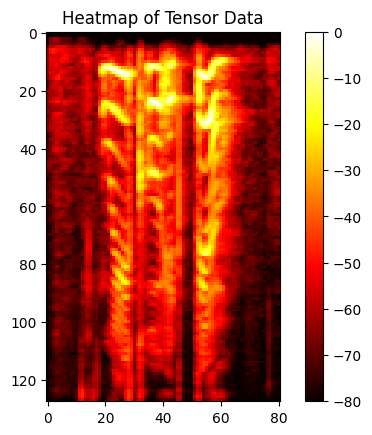

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 텐서를 numpy 배열로 변환합니다.


# 히트맵을 생성합니다.
plt.imshow(pseudo_mel[0], cmap='hot', interpolation='nearest')
plt.colorbar()  # 색상 막대를 추가합니다.
plt.title('Heatmap of Tensor Data')
plt.show()

### 14. input mel spectrogram

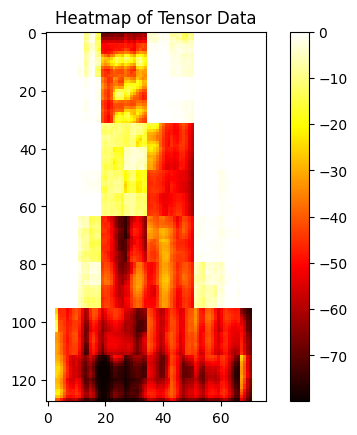

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 텐서를 numpy 배열로 변환합니다.


# 히트맵을 생성합니다.
plt.imshow(new_output, cmap='hot', interpolation='nearest')
plt.colorbar()  # 색상 막대를 추가합니다.
plt.title('Heatmap of Tensor Data')
plt.show()

audio 를 mel spectrogram으로 바꾼 이상 audio는 1차원 데이터에서 2차원 데이터로 변환됨.
이 이후에는 사실상 이미지 데이터와 같게 봐도 됨.
노이즈 제거의 측면에서 encoder-decoder를 썼으나 training이 덜 되었는지 잘 안됨.
GAN같은 이미지 생성의 측면에서 바라보아야 함.